# Project Hypothesis
<b>We believe that the words contained in each tweet are a good indicator of whether they're about a real disaster or not.</b>

In [1]:
import numpy as np # linear algebra
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import linear_model, model_selection, preprocessing

# Import
<b>The data was given to us pre-split into train and test datasets. The train dataset will be used to train our model and the test dataset will be used to determine how accurate our training is. If we hadn't been given pre-split data, then we could have used cross validation to determine the best way to split the data, and trained on that.</b>

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# EDA
<b>We want to inspect the data we have so that we know what we're working with. One of our goals with EDA is to determine if the data is suitable for our purposes or if it needs to be cleaned.</b>

In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


<b>Example non-disaster tweet from training data</b>

In [5]:
print(train_df[train_df["target"] == 0]["text"].values[1])

I love fruits


<b>Example disaster tweet from training data</b>

In [6]:
print(train_df[train_df["target"] == 1]["text"].values[1])

Forest fire near La Ronge Sask. Canada


<b>Example unique keywords</b>

In [7]:
train_df.keyword.unique()[:10]

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon'], dtype=object)

# Data Cleaning

<b>Replace NA values with ""</b>

In [8]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [9]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [10]:
train_df.fillna("",inplace = True)
test_df.fillna("",inplace = True)

<b>Remove unnecessary features from data to speed up the cleaning process</b>

In [11]:
del train_df['id']
del test_df['id']
del train_df['keyword']
del train_df['location']
del test_df['keyword']
del test_df['location']

<b>Remove HTML</b>

In [12]:
from bs4 import BeautifulSoup

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

<b>Remove stopwords</b>

In [13]:
from nltk.corpus import stopwords
import string
from string import punctuation

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Remove stopwords
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

<b>Remove square brackets</b>

In [14]:
import re
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

<b>Remove URL's</b>

In [15]:
def remove_urls(text):
    return re.sub(r'http\S+', '', text)

<b>Remove hashtags</b>

In [16]:
def remove_hash(text):
    text = " ".join(word.strip() for word in re.split('#|_', text))
    return text

<b>Run cleaning</b>

In [17]:
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_urls(text)
    text = remove_hash(text)
    text = remove_stopwords(text)
    return text

In [18]:
train_df['clean_text']=train_df['text'].apply(denoise_text)
test_df['clean_text']=test_df['text'].apply(denoise_text)

In [19]:
train_df.head()

,text,target,clean_text
0,Our Deeds are the Reason of this #earthquake M...,1,Deeds Reason earthquake May ALLAH Forgive us
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord..."
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo Ruby Alaska smoke wildfires pou...


# EDA (Visualizations)

<b>Count number of tokens in each tweet</b><br/>
Result: Most tweets contain 9-12 tokens.

In [20]:
def len_text(text):
    return len(text.split())

train_df['len'] = train_df['clean_text'].apply(len_text)

In [21]:
train_df.head()

,text,target,clean_text,len
0,Our Deeds are the Reason of this #earthquake M...,1,Deeds Reason earthquake May ALLAH Forgive us,7
1,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada,7
2,All residents asked to 'shelter in place' are ...,1,residents asked 'shelter place' notified offic...,11
3,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive wildfires evacuation ord...",7
4,Just got sent this photo from Ruby #Alaska as ...,1,got sent photo Ruby Alaska smoke wildfires pou...,9


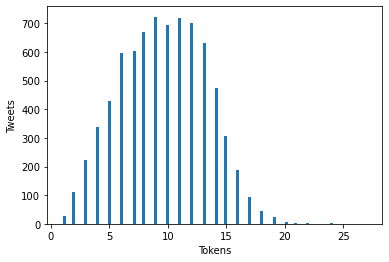

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(train_df['len'] , bins = 100)
plt.xlabel("Tokens")
plt.ylabel("Tweets")
plt.show()

<b>Count number of disaster (1) vs non-disaster (0) tweets</b><br/>
Result: There are more non-disaster tweets than disaster tweets.

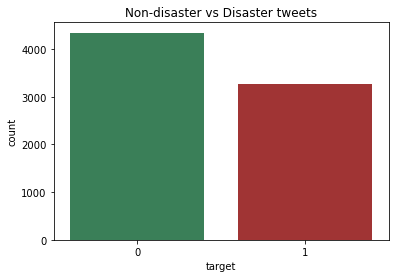

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ["seagreen", "firebrick"]

# Set custom color palette
sns.set_palette(sns.color_palette(colors))

sns.countplot(x = 'target', data = train_df)
plt.title('Non-disaster vs Disaster tweets')
plt.show()

<b>Count the number of characters per tweet</b><br/>
Result: The distribution of characters seems to be about the same for both non-disaster and disaster tweets. 70 characters per tweet appears to be the most common across both.

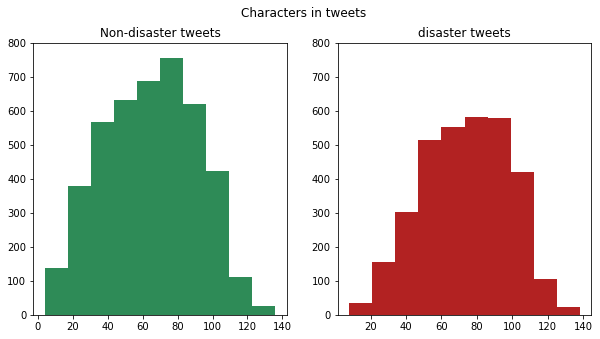

In [24]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==0]['clean_text'].str.len()
ax1.hist(tweet_len,color=colors[0])
ax1.set_title('Non-disaster tweets')
ax1.set_ylim([0,800]) # Change scale to maintain consistency

tweet_len=train_df[train_df['target']==1]['clean_text'].str.len()
ax2.hist(tweet_len,color=colors[1])
ax2.set_title('disaster tweets')
ax2.set_ylim([0,800]) # Change scale to maintain consistency
fig.suptitle('Characters in tweets')
plt.show()

<b>Count the number of words (tokens) per tweet</b><br/>
Result: The distribution of words seems to be about the same for both non-disaster and disaster tweets. 70 characters per tweet appears to be the most common across both.

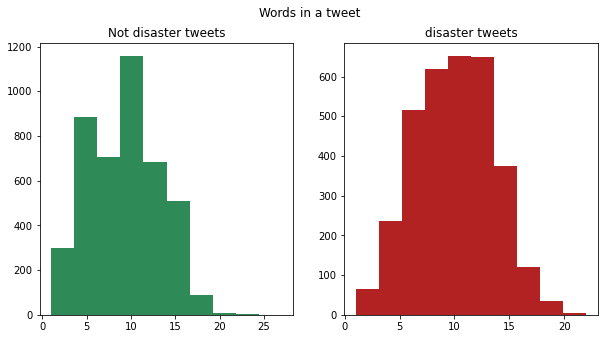

In [25]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==0]['clean_text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color=colors[0])
ax1.set_title('Not disaster tweets')
tweet_len=train_df[train_df['target']==1]['clean_text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color=colors[1])
ax2.set_title('disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

# Count Vectorizer
<b>We want to count the words in each tweet and turn them into data our machine learning model can process. Count Vectorizer can do this for us by converting the text to numbers.</b>

In [26]:
# Create an object of CountVectorizer
cv = CountVectorizer()
print(cv)

CountVectorizer()


<b>To check what Count Vectorizer is doing, we'll look at the first five tweets and count the unique tokens among them.</b><br/>
Result: 37 unique words (tokens) in the first five tweets.

In [27]:
# Get counts for the first five tweets
count_words = cv.fit_transform(train_df["clean_text"][0:5])

print(count_words[0].todense().shape) # each vector is a sparse matrix so using .todense() converts it to a dense matrix

(1, 37)


# Build the model (Ridge Regression)
Our hypothesis assumes that words in a tweet link directly to whether or not that tweet is about an actual disaster. This implies a <b>linear</b> connection between the words and the result, so we need a linear model. We have a huge number of parameters (tokens) for this model and not enough data points to accurately estimate them all. We won't want to use a standard regression algorithm because smaller datasets tend to have poor Least Squares Estimates which can result in overfitting. Instead, we want to shrink (or regularize) the coefficients so that the algorithm will produce low bias and low variance.

<i>Recall:<br/>
<b>Bias</b> is the is the difference in the average prediction of our model and the correct value we are trying to predict.<br/>
<b>Variance</b> is the difference in fits between data sets.<br/></i>

<b>Ridge Regression</b> is one example of a machine learning algorithm that uses regularization. The main idea behind Ridge Regression is to find a model that doesn't fit the training data too well by introducing a small amount of bias. This causes the variance to be consistently lower when testing on new data because the prediction will be less sensitive to each individual token. It does this by shrinking (regularizing) coefficients, pushing them towards '0' values so they work better on new datasets.

Ridge Regression uses Cross Validation to determine the appropriate amount of bias to add based on the lowest calculated variance, which is exactly what we need.

In [28]:
# Create an object of linear model
model = linear_model.RidgeClassifier()

In [29]:
# Create vectors for all tweets
train_vectors = cv.fit_transform(train_df["clean_text"])
test_vectors = cv.transform(test_df["clean_text"])

# Accuracy of Model by Cross Validation
<b>The result shows that our assumption will score roughly 0.67. We can improve this by using any of the following: TFIDF, LSA, LSTM / RNNs.</b>

In [30]:
# Using 5-fold cross validation
scores = model_selection.cross_val_score(model, train_vectors, train_df["target"], cv=5, scoring="f1")
scores

array([0.59449541, 0.44851658, 0.54648343, 0.47977422, 0.66666667])

# Classification
<b>We want to create a new dataframe 'target' in the test dataset similar to the one in the train dataset. We want it to predict whether or not each tweet from the test dataset is about a disaster. The tweets will be labeled as:
 - '0' if not about a disaster
 - '1' if about a disaster
</b>

In [31]:
model.fit(train_vectors, train_df["target"])

RidgeClassifier()

In [32]:
prediction_df = test_df.copy()

prediction_df["target"] = model.predict(test_vectors)

In [33]:
prediction_df.head()

,text,clean_text,target
0,Just happened a terrible car crash,happened terrible car crash,0
1,"Heard about #earthquake is different cities, s...","Heard earthquake different cities, stay safe e...",1
2,"there is a forest fire at spot pond, geese are...","forest fire spot pond, geese fleeing across st...",1
3,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. Spokane wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 China Taiwan,1


# Results

Accuracy
 - Uncleaned data: 65%<br/>
 - Cleaned data 67%<br/>

# Word Cloud

<b>Now that we had a working model, we wanted to know which words the model believed to indicade a disaster and decided to implement a word cloud. We chose this because it is easily understandable by any audience, and helped to convey the data in an aesthetically pleasing way.</b>

In [37]:
# gather all tweets that the model believed to be about a 'disaster'
df_disaster = prediction_df[prediction_df['target']==1]
df_disaster

,text,clean_text,target
1,"Heard about #earthquake is different cities, s...","Heard earthquake different cities, stay safe e...",1
2,"there is a forest fire at spot pond, geese are...","forest fire spot pond, geese fleeing across st...",1
3,Apocalypse lighting. #Spokane #wildfires,Apocalypse lighting. Spokane wildfires,1
4,Typhoon Soudelor kills 28 in China and Taiwan,Typhoon Soudelor kills 28 China Taiwan,1
5,We're shaking...It's an earthquake,We're shaking...It's earthquake,1
...,...,...,...
3257,The death toll in a #IS-suicide car bombing on...,death toll IS-suicide car bombing YPG position...,1
3258,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...,1
3259,Storm in RI worse than last hurricane. My city...,Storm RI worse last hurricane. city&3others ha...,1
3260,Green Line derailment in Chicago http://t.co/U...,Green Line derailment Chicago,1


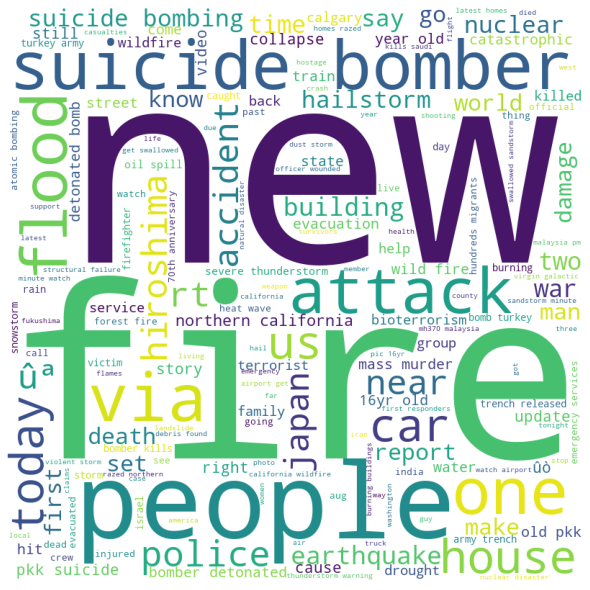

In [40]:
# importing all necessery modules 
from wordcloud import WordCloud, STOPWORDS 
  
comment_words = '' 
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in df_disaster.clean_text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
    comment_words += " ".join(tokens)+" "
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 